In [1]:
import glob
import pandas as pd
import numpy as np
import json
from datetime import datetime

def read_json(json_file):
    with open(json_file) as f:
        lines = f.read().splitlines()
    return [eval(i) for i in lines[1:]]

def get_result_dict(logs):
    result = {}
    for log in logs:
        for l in log:
            key, val = l.split(': ')
            if key not in result:
                result[key] = []
            else:
                result[key].append(val)
    return result

def get_data_from_logs(log, key):
    return [i[key] for i in log]

def get_e2e_time_from_report(report):
    with open(report) as f:
        lines = f.read().splitlines()
    e2e_time = eval(lines[-3].lstrip('\t').split(': ')[1])
    e2e_time = datetime.strptime(e2e_time, "%H:%M:%S.%f")
#     print(e2e_time.second, e2e_time.microsecond)
    e2e_time = e2e_time.second+e2e_time.microsecond / 1000000
    return e2e_time

In [15]:
json_logs = sorted(glob.glob("./*/*/*20_0*/logs/*.json"))
cli_reports = sorted(glob.glob("./*/*/*20_0*/*.log"))

In [16]:
result_df = pd.DataFrame()
for json_log in json_logs:
    try:
        cli_report = [i for i in cli_reports if i.find("/".join(json_log.split('/')[:4])) >= 0][0]
    except IndexError:
        print(json_log, "pass")
        continue
# for json_log, cli_report in sorted(zip(json_logs, cli_reports)):
#     if set(json_log.split('/')[:4]) != set(cli_report.split('/')[:4]):
#         print(json_log.split('/')[:4], cli_report.split('/')[:4])
#         continue

    train_logs = [i for i in read_json(json_log) if i['mode'] == 'train']
    val_logs = [i for i in read_json(json_log) if i['mode'] == 'val']

    model = json_log.split('/')[1]
    dataset, img_per_cls, seed = json_log.split('/')[3].split('_')
    acc = np.max(get_data_from_logs(val_logs, "accuracy_top-1"))
    e2e_time = get_e2e_time_from_report(cli_report)
    time = np.mean(get_data_from_logs(train_logs, "time"))
    data_time = np.mean(get_data_from_logs(train_logs, "data_time"))
    memory = np.max(get_data_from_logs(train_logs, "memory"))


    df = pd.DataFrame([dataset, model, seed, acc, e2e_time, time, data_time, memory]).T
    result_df = pd.concat([result_df, df])

./deit_base_16/outputs/ibean_20_0/logs/20230409_233112.log.json pass


In [4]:
result_df.columns = ["dataset", "model", "seed", "top-1", "E2E_time", "time", "data_time", "memory"]

In [5]:
result_df['top-1'] = pd.to_numeric(result_df['top-1'])
result_df['E2E_time'] = pd.to_numeric(result_df['E2E_time'])
result_df['time'] = pd.to_numeric(result_df['time'])
result_df['data_time'] = pd.to_numeric(result_df['data_time'])
result_df['memory'] = pd.to_numeric(result_df['memory'])

mean_std_df = result_df.groupby(['model', 'dataset', 'memory']).agg({'top-1': ['mean', 'std'], 'E2E_time': ['mean', 'std'], 'time': ['mean', 'std'], 'data_time': ['mean', 'std']})

In [6]:
mean_std_df

top-1             E2E_time  \
                                            mean       std       mean   
model                dataset    memory                                  
clip_base_16         ibean      2380    0.541355  0.042532  20.376209   
                     imagewoof2 2380    0.192160       NaN   3.987957   
                     xray       2380    0.600000       NaN  25.280714   
clip_base_32         ibean      1731    0.556390       NaN  27.265015   
                     imagewoof2 1731    0.175110       NaN  37.303035   
                     xray       1731    0.650000       NaN  35.083919   
deit_base_16         imagewoof2 2286    0.986260       NaN   0.101122   
                     xray       2286    0.900000       NaN  27.955150   
deit_small_16        ibean      792     0.902260       NaN  24.993691   
                     imagewoof2 792     0.972510       NaN  27.061608   
                     xray       792     0.950000       NaN  14.058996   
deit_tiny_16         ibean      312     0.759400       NaN  12.087812   
                     imagewoof2 312     0.927210       NaN  22.256327   
                     xray       312     0.950000       NaN  10.784456   
efficientnet_b0      ibean      629     0.909770       NaN  21.923715   
                     imagewoof2 629     0.892340       NaN  30.799634   
                     xray       629     0.900000       NaN  11.165651   
efficientnet_v2_s    ibean      955     0.909770       NaN  53.724078   
                     imagewoof2 955     0.792570       NaN  43.664308   
                     xray       955     0.800000       NaN  36.709515   
mobilenet_v3_large_1 ibean      322     0.894740       NaN  24.946622   
                     imagewoof2 322     0.859510       NaN  38.396633   
                     xray       322     0.950000       NaN   9.657407   
vit_base_16          ibean      2375    0.556390       NaN  36.408693   
                     imagewoof2 2375    0.203360       NaN  35.800641   
                     xray       2375    0.750000       NaN  33.326235   
vit_base_32          ibean      1729    0.774440       NaN   8.664927   
                     imagewoof2 1729    0.476710       NaN   7.917307   
                     xray       1729    0.600000       NaN  25.243022   

                                                       time            \
                                              std      mean       std   
model                dataset    memory                                  
clip_base_16         ibean      2380    20.340562  0.078634  0.000475   
                     imagewoof2 2380          NaN  0.077621       NaN   
                     xray       2380          NaN  0.093907       NaN   
clip_base_32         ibean      1731          NaN  0.046385       NaN   
                     imagewoof2 1731          NaN  0.043476       NaN   
                     xray       1731          NaN  0.059289       NaN   
deit_base_16         imagewoof2 2286          NaN  0.076455       NaN   
                     xray       2286          NaN  0.093055       NaN   
deit_small_16        ibean      792           NaN  0.037317       NaN   
                     imagewoof2 792           NaN  0.034515       NaN   
                     xray       792           NaN  0.055554       NaN   
deit_tiny_16         ibean      312           NaN  0.031709       NaN   
                     imagewoof2 312           NaN  0.028209       NaN   
                     xray       312           NaN  0.054321       NaN   
efficientnet_b0      ibean      629           NaN  0.051098       NaN   
                     imagewoof2 629           NaN  0.047909       NaN   
                     xray       629           NaN  0.066063       NaN   
efficientnet_v2_s    ibean      955           NaN  0.103723       NaN   
                     imagewoof2 955           NaN  0.100120       NaN   
                     xray       955           NaN  0.118179       NaN   
mobilenet_v3_large_1 ibean 

In [7]:
mean_df = result_df.groupby(['model', 'dataset', 'memory']).agg({'top-1': ['mean'], 'E2E_time': ['mean'], 'time': ['mean'], 'data_time': ['mean']}).reset_index()

In [8]:
mean_df

,model,dataset,memory,top-1,E2E_time,time,data_time
,,,,mean,mean,mean,mean
0,clip_base_16,ibean,2380,0.541355,20.376209,0.078634,0.006315
1,clip_base_16,imagewoof2,2380,0.192160,3.987957,0.077621,0.002581
2,clip_base_16,xray,2380,0.600000,25.280714,0.093907,0.017649
3,clip_base_32,ibean,1731,0.556390,27.265015,0.046385,0.006049
4,clip_base_32,imagewoof2,1731,0.175110,37.303035,0.043476,0.002465
5,clip_base_32,xray,1731,0.650000,35.083919,0.059289,0.016833
6,deit_base_16,imagewoof2,2286,0.986260,0.101122,0.076455,0.002701
7,deit_base_16,xray,2286,0.900000,27.955150,0.093055,0.018056
8,deit_small_16,ibean,792,0.902260,24.993691,0.037317,0.006275


In [9]:
# mean_std_df.round(4).sort_values(by=['dataset', 'model']).to_excel("final_per_dataset.xlsx")

In [10]:
model_df = result_df.groupby(['model']).agg({'top-1': ['mean'], 'E2E_time': ['mean'], 'time': ['mean'], 'data_time': ['mean']}).reset_index()

In [11]:
model_df

,model,top-1,E2E_time,time,data_time
,,mean,mean,mean,mean
0,clip_base_16,0.468718,17.505273,0.082199,0.008215
1,clip_base_32,0.460500,33.217323,0.049716,0.008449
2,deit_base_16,0.943130,14.028136,0.084755,0.010378
3,deit_small_16,0.941590,22.038098,0.042462,0.010439
4,deit_tiny_16,0.878870,15.042865,0.038080,0.012151
5,efficientnet_b0,0.900703,21.296333,0.055024,0.009164
6,efficientnet_v2_s,0.834113,44.699300,0.107340,0.008898
7,mobilenet_v3_large_1,0.901417,24.333554,0.044343,0.009908
8,vit_base_16,0.503250,35.178523,0.083026,0.008823


In [17]:
model_df['throughput'] = [
    36.33,
    103.61,
    36.33,
    134.58,
    390.21,
    957.88,
    192.20,
    2017.52,
    36.33,
    103.61]


In [18]:
colors = {'efficientnet_b0':'blue',
          'efficientnet_v2_s':'red', 
          'mobilenet_v3_large_1':'green',
          'vit_base_16':'purple',
          'vit_base_32':'brown',
          'deit_base_16':'purple',
          'deit_small_16': 'navy',
          'deit_tiny_16': 'pink',
          'clip_base_16': 'purple',
          'clip_base_32': 'brown'
         }

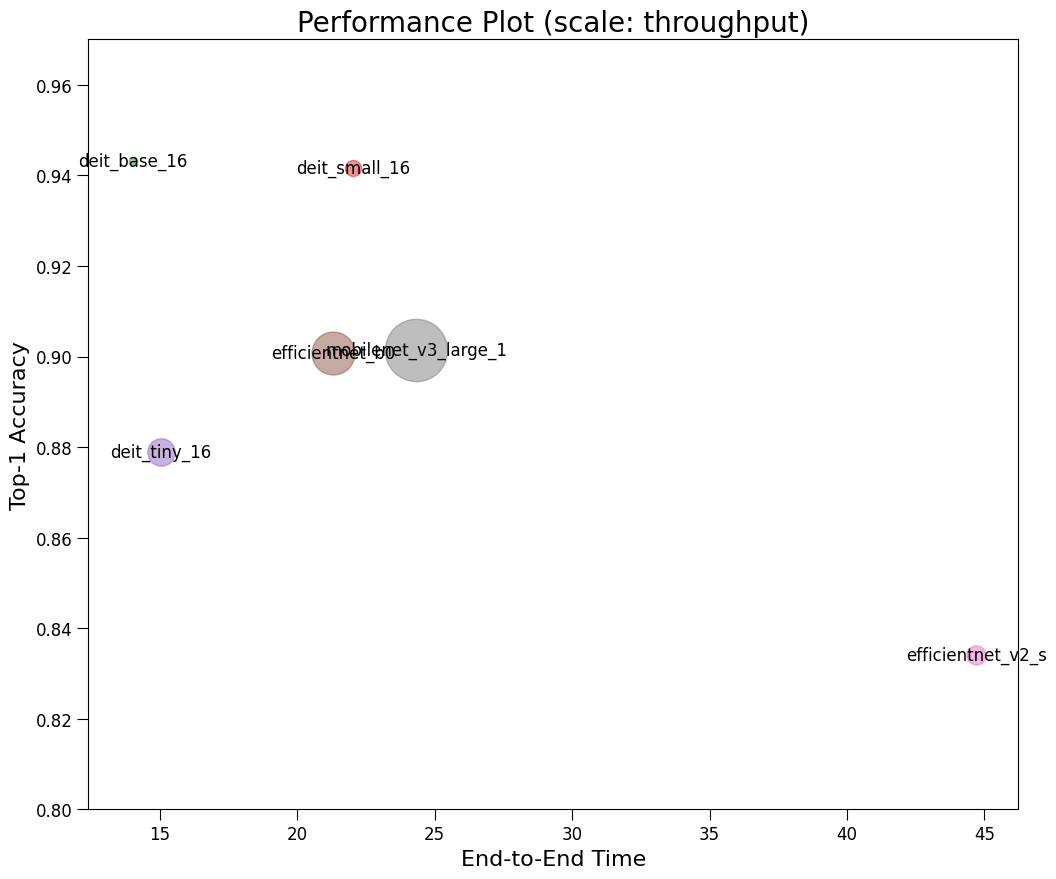

In [22]:
import matplotlib.pyplot as plt
# df = pd.concat([model_df, frozen_df]).reset_index(drop=True)
df = model_df
bubble_sizes = df['throughput']

# plt.figure()
# Create the bubble plot with text labels
fig, ax = plt.subplots(figsize=(12, 10))
for i in range(len(df)):
    ax.scatter(df['E2E_time']['mean'][i], df['top-1']['mean'][i], s=bubble_sizes[i], 
               alpha=0.5)
    ax.annotate(df['model'][i], (df['E2E_time']['mean'][i], df['top-1']['mean'][i]), 
                ha='center', va='center', fontsize=12)

# Set axis labels and title with larger font size
plt.xlabel('End-to-End Time', fontsize=16)
plt.ylabel('Top-1 Accuracy', fontsize=16)
plt.title('Performance Plot (scale: throughput)', fontsize=20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim([35, 95])
plt.ylim([0.8, 0.97])
ax.tick_params(axis='both', which='major', labelsize=12, size=8)

# Save the plot with high resolution
# plt.savefig('bubble_plot_final_big.png', dpi=300)

# Show the plot
plt.show()